## Import packages.

In [1]:
import sys

In [2]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as pl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.axes as ax
import pandas as pd
import pylab as plt
import numpy as np
import math
import nltk
import string
import spacy
nlp = spacy.load('en_core_web_sm')

import pickle as pickle
import gudhi as gd

from gudhi.representations import *
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from sklearn.manifold import MDS

from nltk.corpus import wordnet as wn
from nltk import pos_tag
from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from itertools import count
from itertools import cycle
from pandas import DataFrame
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import LogFormatter
from matplotlib.font_manager import FontProperties
from matplotlib import ticker
from matplotlib import rc
from collections import defaultdict

# Directed graphs documentation: https://networkx.org/documentation/latest/_modules/networkx/classes/digraph.html

## 1) Define *some* initial functions to be used.

### New colormap:

In [3]:
top = cm.get_cmap('summer', 256)
# bottom = cm.get_cmap('autumn_r', 256)
bottom = cm.get_cmap('spring_r', 256)

newcolors = np.vstack((top(np.linspace(0.25, 1, 64)),
                       bottom(np.linspace(0, 0.75, 192))))
newcmp = ListedColormap(newcolors, name='GreenRedish')

### Clean text:

#### *Note: uncomment the nouns row to build other kind of graph.*

In [4]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # tags the words
    text = nltk.pos_tag(text)
    # keeps only the nouns
    text = [word for word, pos in text if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
    return(text)

### Build WordNet graph:

In [5]:
def wordnet_graph(words):    
    """
    Construct a graph where each word is a vertex.
    """   
    graph = nx.DiGraph()
    labels = {}
    seen = set()
    degrees = graph.degree() # nearest neighbour definitions of each word.
    definition_list = set() # collection of individual words used in the definition of other words.
    full_definition = set() # the complete definition of each word.
    
    def recurse(s):
        if not s in seen:
            # adds the word in synset form: "Synset('word.n.01')", to the seen() set.
            seen.add(s)
            # takes synset and transforms into 'word' format.
            sw = s.name().split(".")[0]
            # add a node in the form: 'word', to the graph.
            graph.add_node(sw)
            # returns definition of the synset i.e. using the Synset('word.n.01') format.
            definition = s.definition()
            # clean the text by removing 'stop' words and nouns.
            definition_split = clean_text(definition)
            # adds the full definition of the word to a set.
            full_definition.add(definition)
            
            for d in definition_split:
                # takes all words from the 'defined' list:
                graph.add_node(d)
                graph.add_edge(sw, d)
                definition_list.add(d)
                
                ds = wn.synsets(d)
                
                # Pass statement 
                if len(ds)>0:
                    for i in ds:
                        s2 = wn.synsets(d)[0]
                        recurse(s2)
                    pass
    
    for word in words:
        # takes all synonyms of the word:
        synsets = wn.synsets(word)
        
        for synset in synsets:
            s = wn.synsets(word)[0] ## what would happen if did not take the first one synset?
            recurse(s)
        
    return graph, seen, degrees, definition_list, full_definition

## 2) Take some document off of Brown Corpus:

#### *Text corpora location: http://icame.uib.no/brown/bcm.html#tc, Accessing text corpora: https://www.nltk.org/book/ch02.html.*

In [6]:
text_words = nltk.Text(nltk.corpus.brown.words(fileids=['ca40'])) # TIME magazine - January 13, 1961.

In [7]:
len(text_words)

2340

In [8]:
graph, seen, degrees, definition_list, full_definition = wordnet_graph(text_words)

In [9]:
len(graph)

5062

### Remove self-loops (where a word is used inside the defition of itself) as this can be considered to be redundant:

In [10]:
graph.remove_edges_from(nx.selfloop_edges(graph))

In [11]:
len(graph)

5062

## 3) Find the strongly connected components inside a graph.

### Find SCC's:

In [12]:
nx.number_strongly_connected_components(graph)

4300

In [13]:
S = [graph.subgraph(c).copy() for c in nx.strongly_connected_components(graph)]

In [16]:
GS = []

for ss in range(len(S)):
    if len(S[ss].nodes)>1:
        GS.append(S[ss])

In [17]:
len(GS)

67

In [18]:
GS[0].edges

OutEdgeView([('information', 'message'), ('communication', 'information'), ('message', 'communication')])

In [19]:
def biggest_connected_subgraph(G):
    if G.is_directed():
        components = nx.strongly_connected_components(G)
    biggest = max(components, key=len)
    
    return G.subgraph(biggest)

In [20]:
len(biggest_connected_subgraph(graph))

668

In [21]:
print("Length of text document: ", len(text_words))
print("Number of nodes inside graph: ", len(graph.nodes()))
print("Number of edges inside graph: ", len(graph.edges()))
print("Number of nodes inside SCC: ", len(biggest_connected_subgraph(graph).nodes()))
print("Number of edges inside SCC: ", len(biggest_connected_subgraph(graph).edges()))

Length of text document:  2340
Number of nodes inside graph:  5062
Number of edges inside graph:  11579
Number of nodes inside SCC:  668
Number of edges inside SCC:  1502


### Now select only the largest SCC:

In [22]:
def strongly_connected_component_subgraphs(G, copy=True):
    
    for comp in strongly_connected_components(G):
        if copy:
            yield G.subgraph(comp).copy()
            
        else:
            yield G.subgraph(comp) 

In [23]:
max_Gc = max(nx.strongly_connected_component_subgraphs(graph), key=len)

In [24]:
len(list(max_Gc))

668

## 4) Define distance measures between vertices on graph.

### Create binary matrix using the np.distance_matrix:

In [25]:
from sklearn.neighbors import kneighbors_graph

### Distance matrix:

In [26]:
np_dist_matrix = nx.floyd_warshall_numpy(max_Gc) # numpy distance matrix.

np_binary_matrix = (np_dist_matrix == 1)*float(1) # return binary matrix with 'True' only if nearest neighbour, no self-loops.

binary_array = np.asarray(np_binary_matrix) # returns array.

#### *Number of nodes and edges in the graph:*

In [27]:
n_nodes = graph.number_of_nodes()
n_edges = graph.size()
scc_n_nodes = max_Gc.number_of_nodes()
scc_n_edges = max_Gc.size()

In [28]:
print("Numer of nodes inside WordNet graph: ", n_nodes)
print("Numer of edges inside WordNet graph: ", n_edges)
print("Numer of nodes inside GSCC: ", scc_n_nodes)
print("Numer of edges inside GSCC: ", scc_n_edges)

Numer of nodes inside WordNet graph:  5062
Numer of edges inside WordNet graph:  11579
Numer of nodes inside GSCC:  668
Numer of edges inside GSCC:  1502


## 5) Synthesise graphs.

### Build random configuration model graph:

In [29]:
scc_din = list(d for n,d in max_Gc.in_degree())

scc_dout = list(d for n,d in max_Gc.out_degree())

sccG = nx.directed_configuration_model(scc_din, scc_dout, create_using=nx.DiGraph(), seed=None)

In [30]:
len(sccG)

668

In [31]:
scc_dist_matrix = nx.floyd_warshall_numpy(sccG)

len(scc_dist_matrix)

668

### Plot degree distribution of one configuration model:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


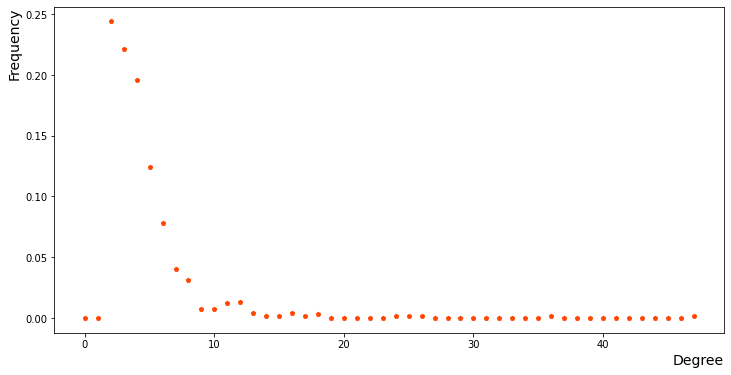

In [32]:
scc_degree = nx.degree_histogram(sccG)
x=range(len(scc_degree))
y=[z/float(sum(scc_degree)) for z in scc_degree]

degree_dist = plt.figure(figsize=(12, 6))
plt.scatter(x, y, s=20, marker="p", color="orangered")
plt.xlabel('Degree', size=14, loc='right')
plt.ylabel('Frequency', size=14, loc='top')
# plt.title('Degree distribution')
plt.show()
degree_dist.savefig('degree_dist.png')

### Create a *cycle* function for detection of connected components:

In [47]:
def mcmp(dmatrix):
    mcmp1 = []
    
    
    for T in range(round(len(dmatrix)/30)): # Round to the nearest integer.
        CMP = []
        
        for i in range(len(dmatrix)):
            # Converts boolean to integer array.
            x = ( np.logical_and( dmatrix[i,:]<T , dmatrix[:,i].transpose()<T ) )*1
            rowsum = x.sum()
            CMP.append(rowsum)
        
        m1 = max(CMP)
    
        mcmp1.append(m1)
    
    return mcmp1

### Generate many synthesised graphs and check for *cycles* forming on them:

In [48]:
scc_random_graphs = []
for gi in range(0,10):
    scc_random_graphs.append( nx.directed_configuration_model(scc_din, scc_dout, create_using = nx.DiGraph(), seed=None) )

scc_random_maxC = []
for mci in range(len(scc_random_graphs)):
    scc_random_maxC.append( max(nx.strongly_connected_component_subgraphs(scc_random_graphs[mci]), key=len) )
    
scc_random_dist_matrix = []
for di in range(len(scc_random_maxC)):
    scc_random_dist_matrix.append( nx.floyd_warshall_numpy(scc_random_maxC[di]) )
    
scc_random_mcmp = []
for scci in range(len(scc_random_dist_matrix)):
    scc_random_mcmp.append( mcmp(scc_random_dist_matrix[scci]) )

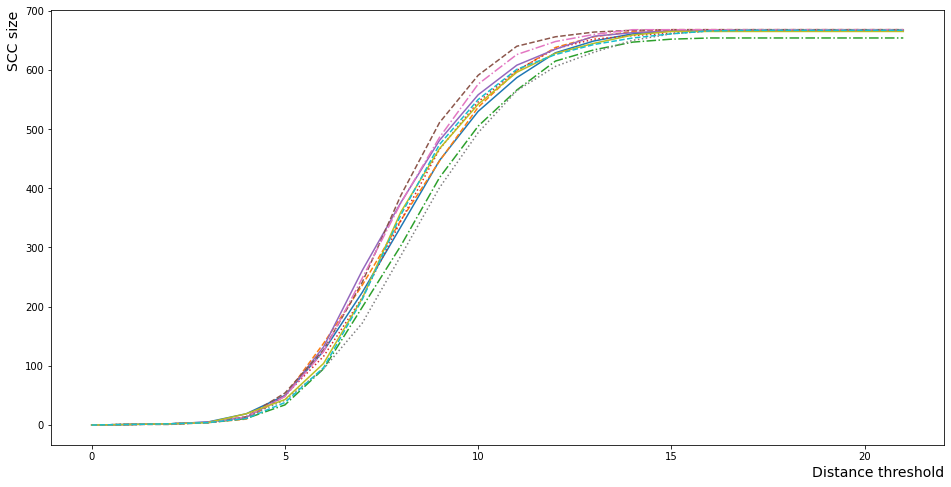

In [49]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

fig = plt.figure(figsize=(16, 8))

for lst in scc_random_mcmp:
    plt.plot(lst, next(linecycles))
    
plt.xlabel('Distance threshold', size=14, loc='right')
plt.ylabel('SCC size', size=14, loc='top')
plt.show()

### Compare against *original* SCC graph:

In [50]:
np_mcmp = mcmp(np_dist_matrix)

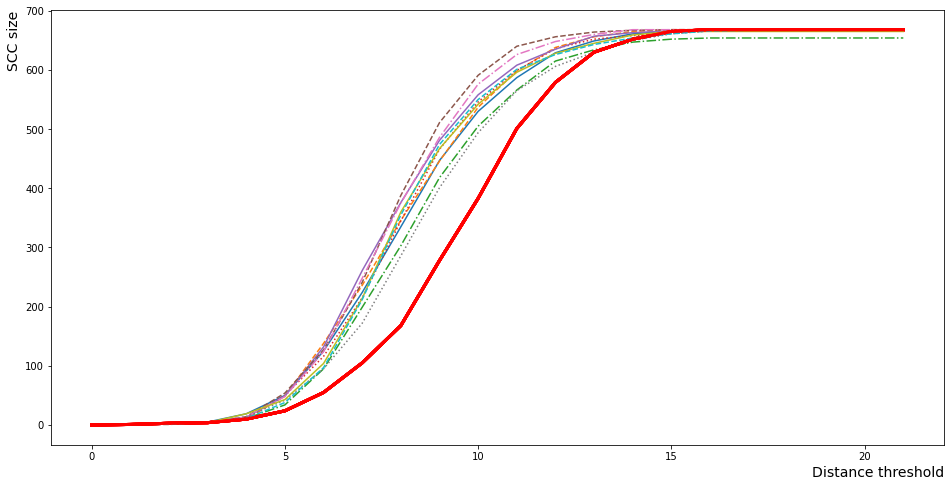

In [51]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

loops_forming = plt.figure(figsize=(16, 8))

for lst in scc_random_mcmp:
    plt.plot(lst, next(linecycles))
    plt.plot(np_mcmp, linewidth=3, color='red')

plt.xlabel('Distance threshold', size=14, loc='right')
plt.ylabel('SCC size', size=14, loc='top')
plt.show()
loops_forming.savefig('loops_forming.png')

## 6) Persistence homology:

In [36]:
import numpy as np
import pandas as pd
import pickle as pickle
import gudhi as gd

from gudhi.representations import *
from pylab import *
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from sklearn.manifold import MDS

### Convert distance numpy distance matrix to data frame:

In [37]:
distance_matrix = nx.floyd_warshall_numpy(max_Gc)  # numpy matrix

distance_matrix_df = coo_matrix(distance_matrix)

distance_matrix_df = pd.DataFrame.sparse.from_spmatrix(distance_matrix_df) # must be converted to pd dataframe for RipsComplex.

### 6a) Rips complex:

In [38]:
Rips_complex_maxSCC = gd.RipsComplex(
    distance_matrix = distance_matrix_df.values
#     ,max_edge_length = 4.0
)

In [39]:
Rips_simplex_tree_maxSCC = Rips_complex_maxSCC.create_simplex_tree(max_dimension = 2)

In [40]:
BarCodes_Rips = Rips_simplex_tree_maxSCC.persistence()

### h0 dimension:

In [41]:
Rips_simplex_tree_maxSCC.persistence_intervals_in_dimension(0)

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ...,
       [ 0.,  3.],
       [ 0.,  3.],
       [ 0., inf]])

### h1 dimension:

In [42]:
Rips_simplex_tree_maxSCC.persistence_intervals_in_dimension(1)

array([[1., 2.],
       [1., 2.],
       [1., 2.],
       ...,
       [3., 6.],
       [2., 7.],
       [3., 8.]])

### Calculate Rips complex:

In [45]:
scc_average_dist_matrix = []
for adm in range(len(scc_random_dist_matrix)): # we set the length of this parameter earlier.
    scc_average_dist_matrix.append( (scc_random_dist_matrix[adm]+scc_random_dist_matrix[adm].transpose())/2 )
    
scc_mds_model = MDS(n_components=2, random_state=123, dissimilarity='precomputed')

scc_mds_fit = []
for mds in range(len(scc_average_dist_matrix)):
    scc_mds_fit.append( scc_mds_model.fit(scc_average_dist_matrix[mds]) )
    
scc_mds_coords = []
for cord in range(len(scc_mds_fit)):
    scc_mds_coords.append( scc_mds_model.fit_transform(scc_average_dist_matrix[cord]) )
    
scc_mds_rips_complex = []
for rc in range(len(scc_mds_coords)):
    scc_mds_rips_complex.append( gd.RipsComplex(scc_mds_coords[rc]).create_simplex_tree(max_dimension=2) )

### Calculate persistence:

In [47]:
scc_persistence = []

for per in range(len(scc_mds_rips_complex)):
    scc_persistence.append( scc_mds_rips_complex[per].persistence() )

In [48]:
BC = gd.representations.BettiCurve(resolution=100)

scc_bc0 = []
for bc0 in range(len(scc_mds_rips_complex)):
    scc_bc0.append( BC.fit_transform([scc_mds_rips_complex[bc0].persistence_intervals_in_dimension(0)[:-1]]) )
    
scc_bc1 = []
for bc1 in range(len(scc_mds_rips_complex)):
    scc_bc1.append( BC.fit_transform([scc_mds_rips_complex[bc1].persistence_intervals_in_dimension(1)]) )

### Plot betti curves:

#### h0:

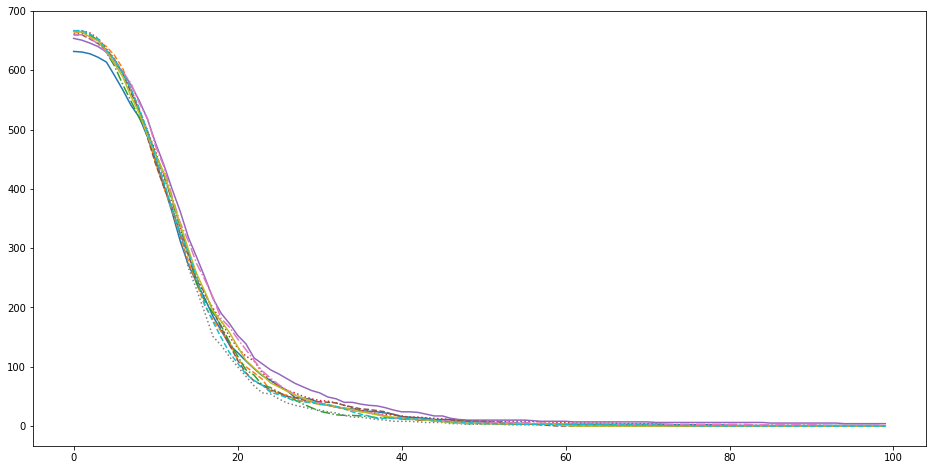

In [49]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

plt.figure(figsize=(16, 8))

for bc0 in scc_bc0:
    plt.plot(bc0[0], next(linecycles))

plt.show()

#### h1:

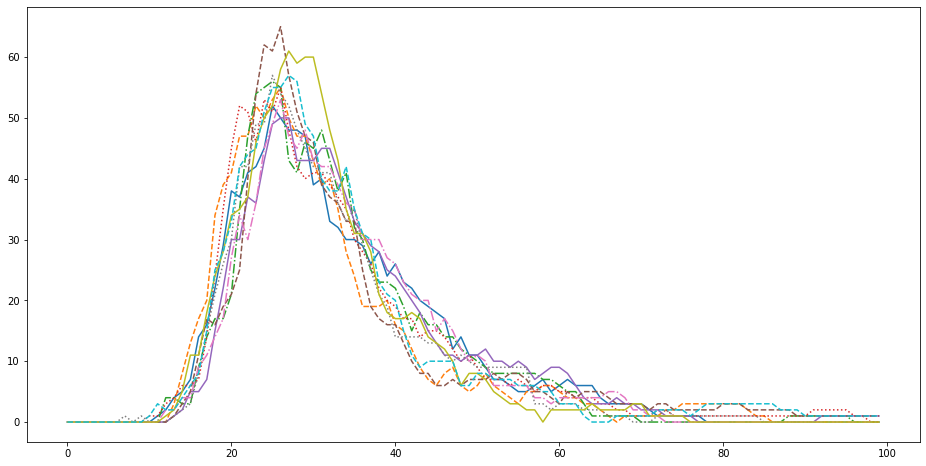

In [50]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

plt.figure(figsize=(16, 8))

for bc1 in scc_bc1:
    plt.plot(bc1[0], next(linecycles))

plt.show()

### 6.b) Reduction of *original* distance matrix for using multi-dimensional scaling:

In [51]:
avg_distance_matrix = ( distance_matrix+distance_matrix.transpose() )/2

node_list = list(max_Gc.nodes())

In [52]:
mds_model = MDS(n_components=2, random_state=123, dissimilarity='precomputed')

mds_fit = mds_model.fit(avg_distance_matrix)

mds_coords = mds_model.fit_transform(avg_distance_matrix)

In [53]:
mds_coords.shape

(668, 2)

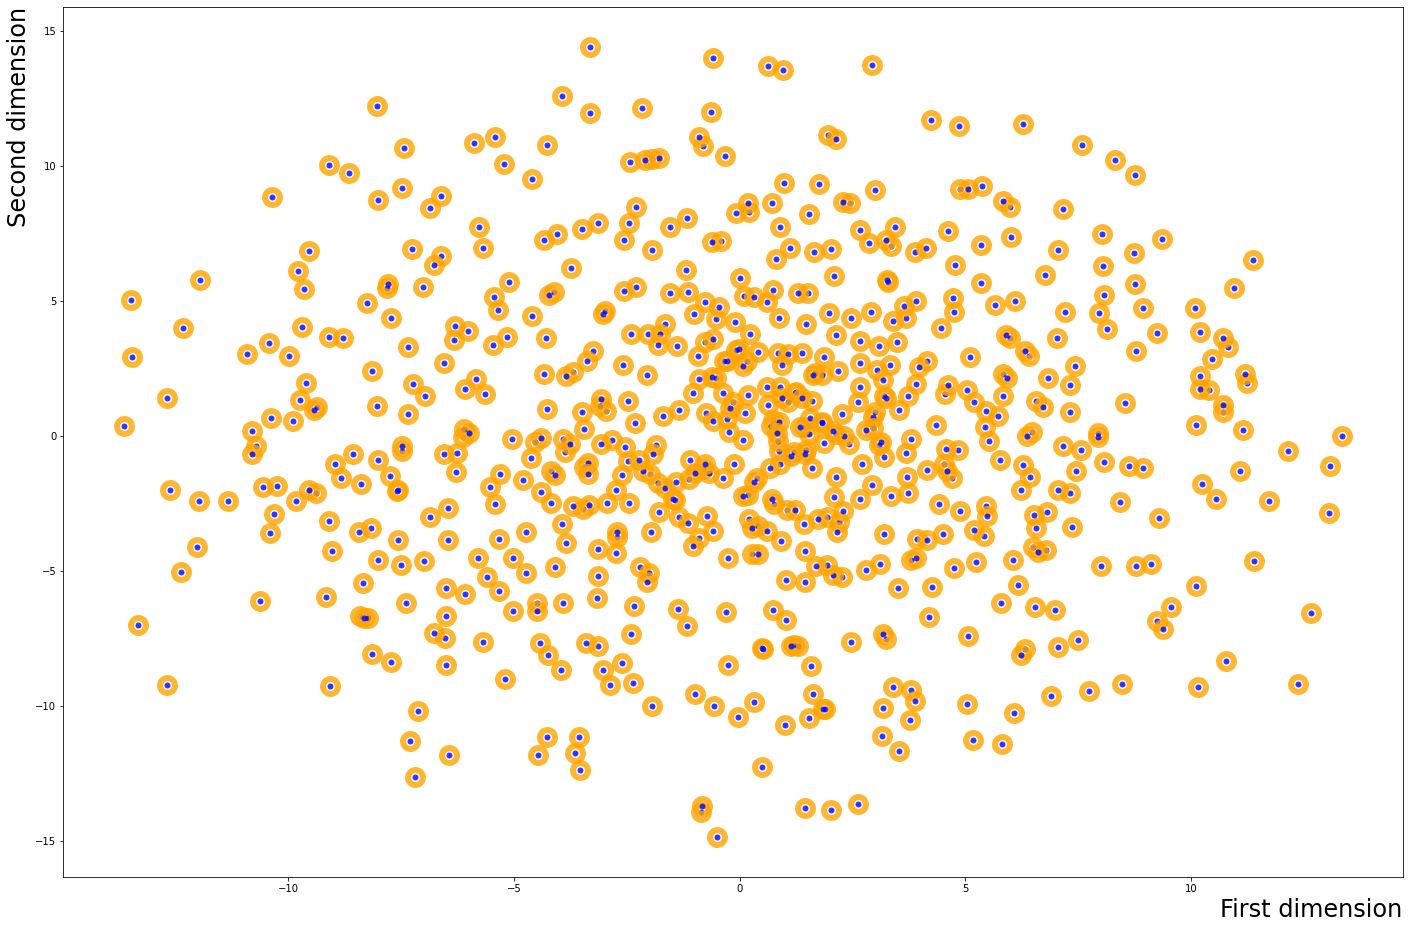

In [54]:
dissimilarity_homology = plt.figure(figsize=(24, 16))
plt.scatter(mds_coords[:,0], mds_coords[:,1],
            facecolors='blue', 
            edgecolors='orange',
            alpha=0.8,
            linewidths=15
           )
# labels = node_list
# for label, x, y in zip(labels, mds_coords[:,0], mds_coords[:,1]):
#     plt.annotate(
#         label, 
#         (x,y), 
#         xycoords='data'
# #         ,fontsize=10
#     )


plt.xlabel('First dimension', size=24, loc='right')
plt.ylabel('Second dimension', size=24, loc='top')
# plt.title('Dissimilarity among words')
plt.show()

dissimilarity_homology.savefig('dissimilarity_homology.png')

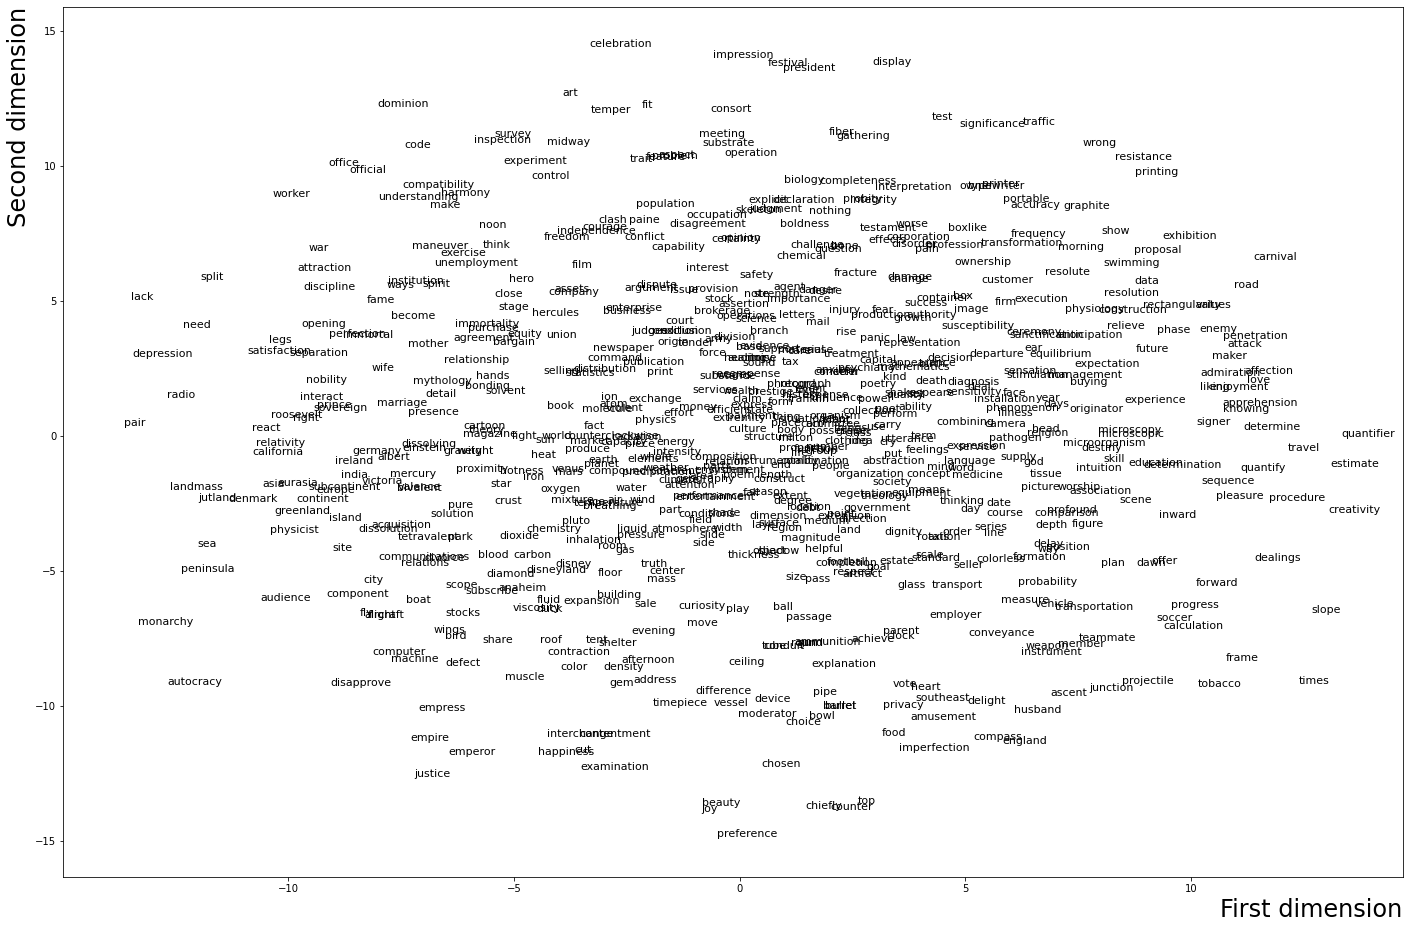

In [55]:
dissimilarity_words_mds = plt.figure(figsize=(24, 16))
plt.scatter(mds_coords[:,0], mds_coords[:,1]
            ,facecolors='none', edgecolors='none' # points in white invisible.
           )
labels = node_list
for label, x, y in zip(labels, mds_coords[:,0], mds_coords[:,1]):
    plt.annotate(
        label, 
        (x,y), 
        xycoords='data'
        ,fontsize=11
    )
plt.xlabel('First dimension', size=24, loc='right')
plt.ylabel('Second dimension', size=24, loc='top')
# plt.title('Dissimilarity among words')
plt.show()

dissimilarity_words_mds.savefig('dissimilarity_words_mds.png')

### 6.c) Compare against original SCC graph:

In [57]:
mds_rips_complex = gd.RipsComplex(mds_coords).create_simplex_tree(max_dimension=2)

rips_persistence = mds_rips_complex.persistence()

BC = gd.representations.BettiCurve(resolution=100)

words_bc0 = BC.fit_transform([mds_rips_complex.persistence_intervals_in_dimension(0)[:-1]])
words_bc1 = BC.fit_transform([mds_rips_complex.persistence_intervals_in_dimension(1)])

#### beta0:

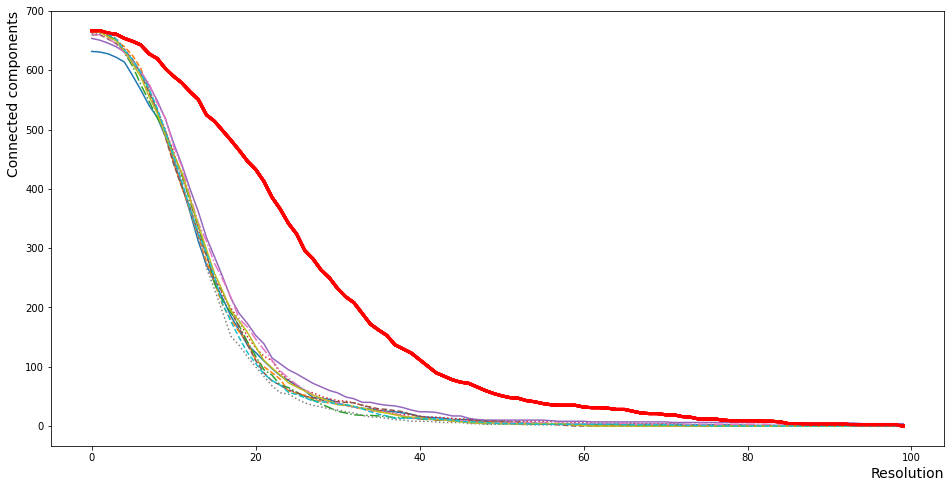

In [58]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

betti0 = plt.figure(figsize=(16, 8))

for bc0 in scc_bc0:
    plt.plot(bc0[0], next(linecycles))
    plt.plot(words_bc0[0], linewidth=3, color='red')

plt.xlabel('Resolution', size=14, loc='right')
plt.ylabel('Connected components', size=14, loc='top')
plt.show()
betti0.savefig('betti0.png')

#### beta1:

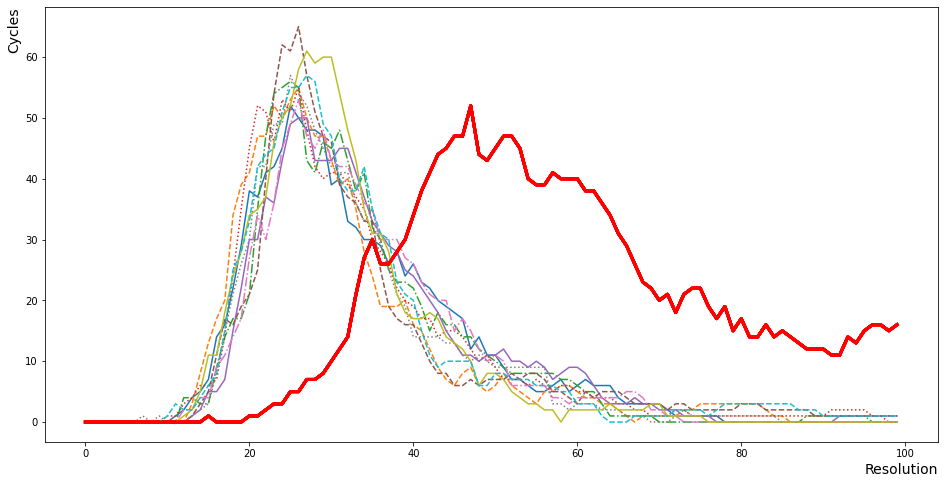

In [59]:
lines = ["-","--","-.",":"]
linecycles = cycle(lines)

betti1 = plt.figure(figsize=(16, 8))

for bc1 in scc_bc1:
    plt.plot(bc1[0], next(linecycles))
    plt.plot(words_bc1[0], linewidth=3, color='red')

plt.xlabel('Resolution', size=14, loc='right')
plt.ylabel('Cycles', size=14, loc='top')
plt.show()
betti1.savefig('betti1.png')

In [60]:
np.mean(bc1[0])

11.67

In [61]:
np.mean(words_bc1[0])

19.16

### 6.d) Some further useful plots and measures:

C:\Users\d.vichansky\Anaconda3\envs\py36\lib\site-packages\gudhi\persistence_graphical_tools.py:510: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = axes.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=cmap)


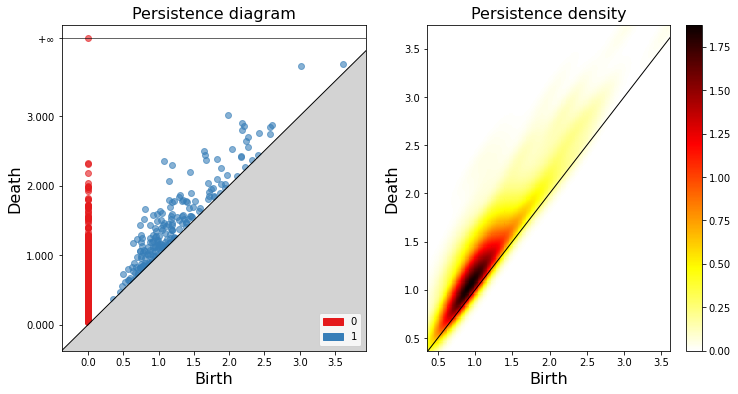

In [62]:
persistence_diagramanddensity,axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
gd.plot_persistence_diagram(rips_persistence, legend=True,axes=axes[0])
gd.plot_persistence_density(rips_persistence, axes=axes[1], legend=True, dimension=1)

persistence_diagramanddensity.savefig('persistence_diagramanddensity.png')

#### Ensure the calculate persistence before proceeding onto following steps:

In [63]:
# rips_persistence = mds_rips_complex.persistence()

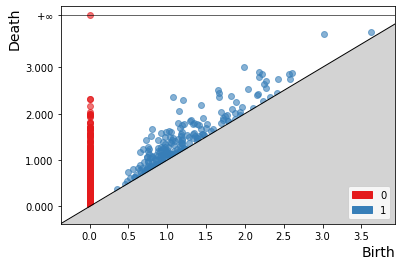

In [64]:
persistence_diagram = gd.plot_persistence_diagram(rips_persistence, legend=True)
persistence_diagram.set_title('Persistence diagram of the Rips complex')

# plt.title('Persistence diagram of the Rips complex')
plt.xlabel('Birth', size=14, loc='right')
plt.ylabel('Death', size=14, loc='top')
plt.title('')
persistence_diagram.figure.savefig('persistence_diagram.png')

C:\Users\d.vichansky\Anaconda3\envs\py36\lib\site-packages\gudhi\persistence_graphical_tools.py:510: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = axes.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=cmap)


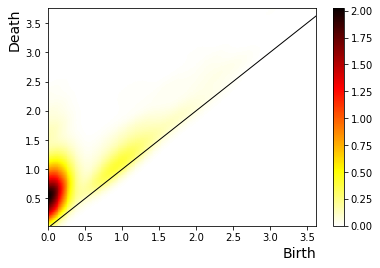

In [65]:
persistence_density = gd.plot_persistence_density(rips_persistence, legend=True)
persistence_density.set_title('Persistence density of the Rips complex')

# plt.title('Persistence density of the Rips complex')
plt.xlabel('Birth', size=14, loc='right')
plt.ylabel('Death', size=14, loc='top')
plt.title('')
persistence_density.figure.savefig('persistence_density.png')

#### Note: The following persistence calculations may confuse the one previously computed, re-order in script as required.

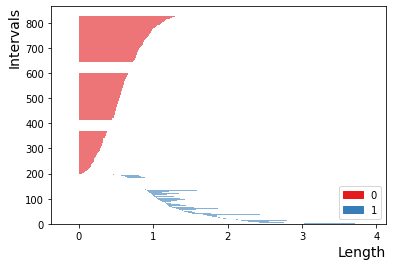

In [66]:
persistence_barcode = gd.plot_persistence_barcode(mds_rips_complex.persistence(), legend=True)
persistence_barcode.set_title('Persistence barcode of the Rips complex')

# plt.title('Persistence barcode of the Rips complex')
plt.xlabel('Length', size=14, loc='right')
plt.ylabel('Intervals', size=14, loc='top')
plt.title('')
persistence_barcode.figure.savefig('persistence_barcode.png')

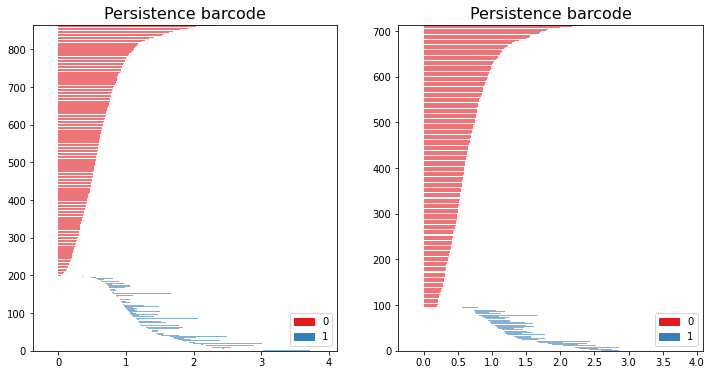

In [67]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
gd.plot_persistence_barcode(mds_rips_complex.persistence(), legend=True, axes=axes[0])
gd.plot_persistence_barcode(mds_rips_complex.persistence(min_persistence=0.2), legend=True, axes=axes[1])
plt.show()